In [27]:
import pandas as pd
import numpy as np
olympics = pd.read_csv('athlete_events.csv')


In [28]:
print(olympics.isnull().sum())

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
region    0
notes     0
dtype: int64


In [29]:
olympics['Medal'].fillna('DNW', inplace = True)

C:\Users\laksh\AppData\Local\Temp\ipykernel_20436\2160398606.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  olympics['Medal'].fillna('DNW', inplace = True)


In [30]:
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

NOC
FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: count, dtype: int64


In [31]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


In [32]:
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

In [33]:
# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6259,ROT,Refugee Olympic Athletes
44161,SGP,June Climene
60733,UNK,Unknown
64317,TUV,Tuvalu
80536,SGP,Rika II
107955,SGP,Singapore-2
234682,SGP,Singapore-1


In [34]:
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

In [35]:
# Glance at the data.
w_gdp = pd.read_csv('world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [36]:
len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

In [37]:
len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

6

In [38]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [39]:
# Read in the population data
w_pop = pd.read_csv('world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [40]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No Medal,China,Not Available,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No Medal,China,Not Available,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,175.0,71.0,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No Medal,Denmark,Not Available,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,175.0,71.0,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,Not Available,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No Medal,Netherlands,Not Available,Netherlands,NLD,2.585680e+11,1.476009e+07


In [41]:
olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age                 0
Height              0
Weight              0
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
region              0
notes               0
Team                0
Country Code     1397
GDP             85540
Population      63735
dtype: int64

In [42]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()

In [51]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

In [56]:
import pandas as pd

# Sample DataFrame creation - replace this with your actual 'olympics_complete_subset' data.
# olympics_complete_subset = pd.DataFrame({
#     'Team': ['Team1', 'Team2', 'Team3', 'Team4'],
#     'Year': [2000, 2004, 2008, 2012],
#     'Event': ['Gymnastics Women\'s Balance Beam', 'Gymnastics Men\'s Horizontal Bar',
#               'Swimming Women\'s 100 metres Freestyle', 'Swimming Men\'s 50 metres Freestyle'],
#     'Medal': ['Gold', 'Gold', 'Bronze', 'Silver'],
#     'Medal_Won': [1, 2, 1, 1]
# })

# Check whether the number of gold medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index=['Team', 'Year', 'Event'],
                                      columns='Medal',
                                      values='Medal_Won',
                                      aggfunc='sum',
                                      fill_value=0).reset_index()

# Filter the events where more than one gold medal was won, indicating a team event.
identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1]

# Extract unique events
team_sports = identify_team_events['Event'].unique()

# Print the unique events
for event in team_sports:
    print(event)

Basketball Men's Basketball
Football Men's Football
Cycling Men's Madison
Hockey Men's Hockey
Sailing Mixed Multihull
Sailing Mixed 5.5 metres
Sailing Mixed Three Person Keelboat
Sailing Mixed Two Person Keelboat
Swimming Men's 4 x 100 metres Medley Relay
Cycling Men's Team Pursuit, 4,000 metres
Hockey Women's Hockey
Equestrianism Mixed Three-Day Event, Team
Rowing Men's Coxless Fours
Rowing Men's Double Sculls
Rowing Women's Coxless Pairs
Tennis Men's Doubles
Beach Volleyball Women's Beach Volleyball
Sailing Men's Two Person Dinghy
Sailing Women's Two Person Dinghy
Swimming Men's 4 x 100 metres Freestyle Relay
Swimming Men's 4 x 200 metres Freestyle Relay
Water Polo Women's Water Polo
Rowing Men's Coxless Pairs
Swimming Women's 4 x 100 metres Freestyle Relay
Swimming Women's 4 x 100 metres Medley Relay
Swimming Women's 4 x 200 metres Freestyle Relay
Canoeing Men's Kayak Fours, 1,000 metres
Sailing Men's Skiff
Rugby Sevens Women's Rugby Sevens
Athletics Women's 4 x 100 metres Relay
Ath

In [57]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

In [58]:
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']

C:\Users\laksh\AppData\Local\Temp\ipykernel_20436\769632578.py:12: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)


In [59]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [60]:
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Team
USA        3731.0
Germany    3463.0
Russia     3291.0
UK         2612.0
Name: All, dtype: float64

Text(0.5, 1.0, 'Olympic Performance Comparison')

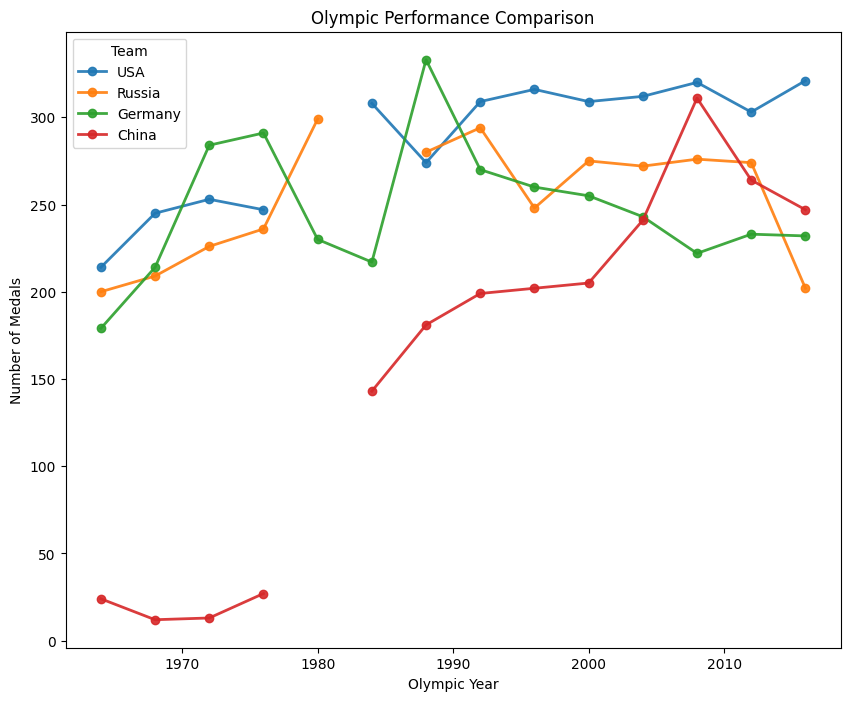

In [73]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index='Year',
                                  columns='Team',
                                  values='Medal_Won_Corrected',
                                  aggfunc='sum')[top_countries]

# Plotting the medal tallies
ax = year_team_medals.plot(linestyle='-', marker='o', alpha=0.9, figsize=(10, 8), linewidth=2)
ax.set_xlabel('Olympic Year')
ax.set_ylabel('Number of Medals')
ax.set_title('Olympic Performance Comparison')


Text(0, 0.5, 'Country')

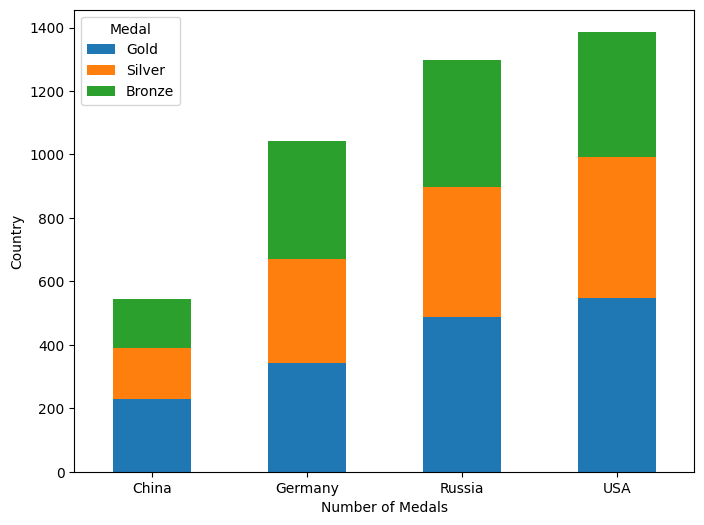

In [74]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1, errors= "ignore")

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

ax = medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
ax.set_xlabel('Number of Medals')
ax.set_ylabel('Country')

In [78]:
# To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.
best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'DNW'], axis = 1, inplace = True, errors="ignore")
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count','No Medal']

best_team_sports.groupby('Team').head(5)

,Team,Event,Gold_Medal_Count,No Medal
0,China,Diving Women's Springboard,8.0,3.0
1,China,Table Tennis Women's Singles,8.0,8.0
2,China,Diving Women's Platform,7.0,7.0
3,China,Weightlifting Men's Lightweight,6.0,6.0
4,China,Badminton Women's Doubles,5.0,6.0
343,Germany,"Equestrianism Mixed Dressage, Team",11.0,2.0
344,Germany,"Canoeing Women's Kayak Doubles, 500 metres",7.0,5.0
345,Germany,Rowing Men's Quadruple Sculls,7.0,4.0
346,Germany,Rowing Women's Quadruple Sculls,6.0,0.0
347,Germany,Athletics Men's Discus Throw,5.0,14.0


In [79]:
# take for each year, the team, name of the athlete and gender of the athlete and drop duplicates. These are values
# where the same athlete is taking part in more than one sport.

# get rows with top countries
row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in top_countries)

year_team_gender = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name', 'Sex']].drop_duplicates()

In [80]:
# Create a pivot table to count gender wise representation of each team in each year
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

In [81]:
chi_data = year_team_gender_count[year_team_gender_count['Team'] == "China"]
chi_data.fillna(0, inplace = True)
chi_data.set_index('Year', inplace = True)

ger_data = year_team_gender_count[year_team_gender_count['Team'] == "Germany"]
ger_data.set_index('Year', inplace = True)

rus_data = year_team_gender_count[year_team_gender_count['Team'] == "Russia"]
rus_data.set_index('Year', inplace = True)

usa_data = year_team_gender_count[year_team_gender_count['Team'] == "USA"]
usa_data.set_index('Year', inplace = True)

C:\Users\laksh\AppData\Local\Temp\ipykernel_20436\2439596988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_data.fillna(0, inplace = True)


In [83]:
# Lets merge contingent size and medals won!
year_team_medals_unstack = year_team_medals.unstack().reset_index()
year_team_medals_unstack.columns = ['Team','Year', 'Medal_Count']

contingent_size_unstack = contingent_size.unstack().reset_index()

contingent_size_unstack.columns = ['Team','Year', 'Contingent']

contingent_medals = contingent_size_unstack.merge(year_team_medals_unstack,
                                                 left_on = ['Team', 'Year'],
                                                 right_on = ['Team', 'Year'])

contingent_medals[['Contingent', 'Medal_Count']].corr()

,Contingent,Medal_Count
Contingent,1.000000,0.941455
Medal_Count,0.941455,1.000000


In [85]:
# merge best team sports with olympics data to get sport for each event.
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold_Medal_Count'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(5).reset_index()

# make a pivot table of the commonalities.
pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,China,Germany,Russia,USA,All
Sport,,,,,
Athletics,0,1,0,2,3
Diving,2,0,0,0,2
Rowing,0,2,0,0,2
Swimming,0,0,0,2,2
Wrestling,0,0,2,0,2
Badminton,1,0,0,0,1
Basketball,0,0,0,1,1
Canoeing,0,1,0,0,1
Equestrianism,0,1,0,0,1


In [86]:
olympics_complete_subset[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
74,1964,Tokyo
11,1968,Mexico City
12,1972,Munich
37,1976,Montreal
70,1980,Moskva
10,1984,Los Angeles
13,1988,Seoul
0,1992,Barcelona
3,1996,Atlanta
2,2000,Sydney


In [87]:
olympics_complete_subset['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

C:\Users\laksh\AppData\Local\Temp\ipykernel_20436\825955963.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  olympics_complete_subset['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)


In [88]:
# city to country mapping dictionary
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics_complete_subset['Country_Host'] = olympics_complete_subset['City'].map(city_to_country)

#print the 
olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')

,Year,Country_Host
74,1964,Japan
11,1968,Mexico
12,1972,Germany
37,1976,Canada
70,1980,Russia
10,1984,USA
13,1988,South Korea
0,1992,Spain
3,1996,USA
2,2000,Australia


In [89]:
# Extract year, host nation and team name from the data
year_host_team = olympics_complete_subset[['Year', 'Country_Host', 'Team']].drop_duplicates()

# check rows where host country is the same as team
row_mask_4 = (year_host_team['Country_Host'] == year_host_team['Team'])

# add years in the year_host_team to capture one previous and one later year
year_host_team['Prev_Year'] = year_host_team['Year'] - 4
year_host_team['Next_Year'] = year_host_team['Year'] + 4

# Subset only where host nation and team were the same
year_host_team = year_host_team[row_mask_4]

# Calculate the medals won in each year where a team played at home. merge year_host_team with medal_tally on year and team
year_host_team_medal = year_host_team.merge(medal_tally,
                                           left_on = ['Year', 'Team'],
                                           right_on = ['Year', 'Team'],
                                           how = 'left')

year_host_team_medal.rename(columns = {'Medal_Won_Corrected' : 'Medal_Won_Host_Year'}, inplace = True)

# Calculate medals won by team in previous year
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Prev_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected': 'Medal_Won_Prev_Year',
                                      'Year_x':'Year'}, inplace = True)

# Calculate the medals won by the team the year after they hosted.
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Next_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Year_x': 'Year',
                                      'Medal_Won_Corrected' : 'Medal_Won_Next_Year'}, inplace = True)

# General formatting changes
year_host_team_medal.drop(['Prev_Year', 'Next_Year'], axis = 1, inplace = True)
year_host_team_medal.sort_values('Year', ascending = True, inplace = True)
year_host_team_medal.reset_index(inplace = True, drop = True)

# column re-ordering
year_host_team_medal = year_host_team_medal.loc[:, ['Year', 'Country_Host', 'Team', 'Medal_Won_Prev_Year', 'Medal_Won_Host_Year', 'Medal_Won_Next_Year']]

year_host_team_medal

,Year,Country_Host,Team,Medal_Won_Prev_Year,Medal_Won_Host_Year,Medal_Won_Next_Year
0,1964,Japan,Japan,NaN,168.0,111.0
1,1968,Mexico,Mexico,58.0,151.0,112.0
2,1972,Germany,Germany,214.0,284.0,291.0
3,1976,Canada,Canada,140.0,180.0,NaN
4,1980,Russia,Russia,236.0,299.0,NaN
5,1984,USA,USA,NaN,308.0,274.0
6,1988,South Korea,South Korea,98.0,227.0,147.0
7,1992,Spain,Spain,131.0,203.0,162.0
8,1996,USA,USA,309.0,316.0,309.0
9,2000,Australia,Australia,225.0,292.0,242.0


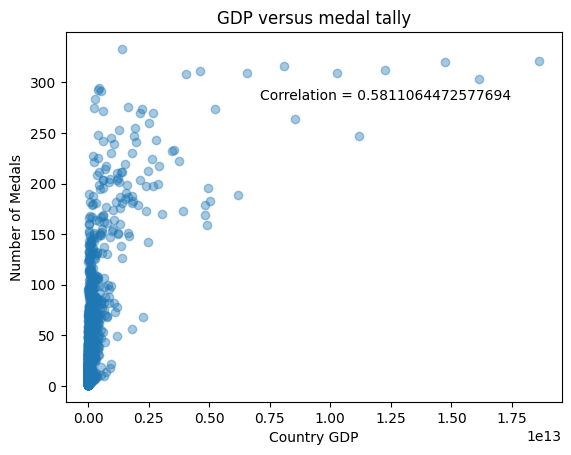

In [91]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported for nanpercentile

# Assuming all the previous code is correct and necessary dataframes and variables are defined

# Use plt.plot() instead of just plot()
plt.plot(medal_tally_gdp.loc[row_mask_5, 'GDP'], 
         medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'], 
         linestyle='none', 
         marker='o', 
         alpha=0.4)

plt.xlabel('Country GDP')
plt.ylabel('Number of Medals')
plt.title('GDP versus medal tally')

# Add text to the plot
plt.text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6), 
         max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
         "Correlation = " + str(correlation))

# Show the plot
plt.show()

In [92]:
# lets create a data frame of athletes with the sport they participated in and the number of medals won.
ath_sport_medal = olympics_complete_subset.groupby(['Team','Name', 'Sport'])['Medal_Won'].agg('sum').reset_index()
ath_sport_medal.sort_values(['Sport', 'Medal_Won'], ascending = [True, False], inplace = True)

# keep only athletes who won medals
medal_mask = ath_sport_medal['Medal_Won'] > 0
ath_sport_medal = ath_sport_medal[medal_mask]

ath_sport_medal.head()

,Team,Name,Sport,Medal_Won
38790,Italy,Ilario Di Bu,Archery,11
4715,Australia,Simon John Fairweather,Archery,10
74125,UK,Alison Jane Williamson (-Conaghan),Archery,10
80673,USA,"Richard Andrew ""Butch"" Johnson",Archery,10
24169,Finland,Tomi Jaakko Poikolainen,Archery,8


In [93]:
# Now lets calculate the number of participations of each athlete. This will be sport wise.
ath_sport_appearance = olympics_complete_subset.groupby(['Team', 'Name', 'Sport'])['NOC'].agg('count').reset_index()

ath_sport_appearance.rename(columns = {'NOC': 'Event_Count'}, inplace = True)

ath_sport_appearance.head()

# lets merge these two.
ath_medal_appearance = ath_sport_medal.merge(ath_sport_appearance,
                                            left_on = ["Team", "Name", "Sport"],
                                            right_on = ['Team', 'Name', 'Sport'],
                                            how = "left")

# Calculate the medal per participation
ath_medal_appearance['Medal_Per_Participation'] = ath_medal_appearance['Medal_Won']/ath_medal_appearance['Event_Count']

ath_medal_appearance.sort_values(['Medal_Per_Participation', 'Medal_Won'], ascending = [False, False], inplace = True)

ath_medal_appearance.head(10)

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
40984,Germany,Andreas Wecker,Gymnastics,32,32,1.0
40985,Bulgaria,Yordan Yovchev Yovchev,Gymnastics,30,30,1.0
64717,USA,"Michael Fred Phelps, II",Swimming,30,30,1.0
40986,Germany,Fabian Hambchen,Gymnastics,26,26,1.0
40987,Brazil,Daniele Matias Hyplito,Gymnastics,24,24,1.0
40988,Bulgaria,Kalofer Petrov Khristozov,Gymnastics,24,24,1.0
40989,Czech Republic,Bohumil Mudk,Gymnastics,24,24,1.0
40990,Czech Republic,Miloslav Netuil,Gymnastics,24,24,1.0
40991,France,Henri Louis Borio,Gymnastics,24,24,1.0
40992,France,Michel Boutard,Gymnastics,24,24,1.0


In [94]:
# filter out athletes with less than 10 total medals.
ath_medal_appearance = ath_medal_appearance[ath_medal_appearance['Medal_Won'] >= 10]

ath_medal_appearance

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
40984,Germany,Andreas Wecker,Gymnastics,32,32,1.0
40985,Bulgaria,Yordan Yovchev Yovchev,Gymnastics,30,30,1.0
64717,USA,"Michael Fred Phelps, II",Swimming,30,30,1.0
40986,Germany,Fabian Hambchen,Gymnastics,26,26,1.0
40987,Brazil,Daniele Matias Hyplito,Gymnastics,24,24,1.0
...,...,...,...,...,...,...
72106,Austria,Werner Schlager,Table Tennis,10,10,1.0
72107,Germany,Jrg Rokopf,Table Tennis,10,10,1.0
72108,Germany,Timo Boll,Table Tennis,10,10,1.0
72109,Sweden,Jan-Ove Waldner,Table Tennis,10,10,1.0


The exploration phase showed that the following factors affect a country's medal tally -

GDP,
Contingent Size,
Population,
Home field advantage

In [95]:
# create the year, team contingent size
year_team_gender = olympics_complete_subset.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Team','Total_Athletes']]
year_team_contingent.head()

,Year,Team,Total_Athletes
0,1964,Afghanistan,8.0
1,1964,Algeria,1.0
2,1964,Argentina,102.0
3,1964,Australia,243.0
4,1964,Austria,56.0


In [96]:
# get year, team and GDP - medal_tally_gdp has it
medal_tally_gdp.head()

,Year,Team,Medal_Won_Corrected,GDP
0,1964,Afghanistan,8.0,8.000000e+08
1,1964,Algeria,7.0,2.909352e+09
2,1964,Argentina,79.0,2.560525e+10
3,1964,Australia,143.0,2.378766e+10
4,1964,Austria,54.0,9.169984e+09


In [97]:
# Get year team population
year_team_pop = olympics_complete_subset.loc[:, ['Year', 'Team', 'Population']].drop_duplicates()
year_team_pop.head()

,Year,Team,Population
0,1992,China,1.164970e+09
1,2012,China,1.350695e+09
2,2000,Finland,5.176209e+06
3,1996,Finland,5.124573e+06
6,2008,Norway,4.768212e+06


In [98]:
# merge all these datasets together
medal_gdp_population = medal_tally_gdp.merge(year_team_pop,
                                            left_on = ['Year', 'Team'],
                                            right_on = ['Year', 'Team'],
                                            how = 'left')

medal_gdp_pop_contingent = medal_gdp_population.merge(year_team_contingent,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')
medal_gdp_pop_contingent.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes
0,1964,Afghanistan,8.0,8.000000e+08,9731361.0,8.0
1,1964,Algeria,7.0,2.909352e+09,12295970.0,1.0
2,1964,Argentina,79.0,2.560525e+10,21953929.0,102.0
3,1964,Australia,143.0,2.378766e+10,11167000.0,243.0
4,1964,Austria,54.0,9.169984e+09,7223801.0,56.0


In [99]:
# get host nation from the data
year_host = olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates()

# merge this with the larger dataset
lin_model_data = medal_gdp_pop_contingent.merge(year_host,
                              left_on = 'Year',
                              right_on = 'Year',
                              how = 'left')

lin_model_data.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes,Country_Host
0,1964,Afghanistan,8.0,8.000000e+08,9731361.0,8.0,Japan
1,1964,Algeria,7.0,2.909352e+09,12295970.0,1.0,Japan
2,1964,Argentina,79.0,2.560525e+10,21953929.0,102.0,Japan
3,1964,Australia,143.0,2.378766e+10,11167000.0,243.0,Japan
4,1964,Austria,54.0,9.169984e+09,7223801.0,56.0,Japan


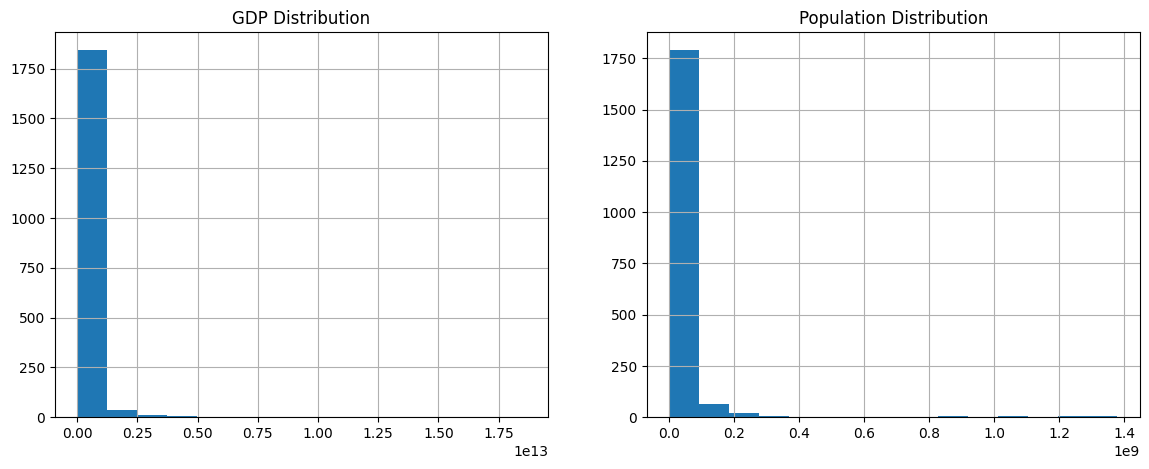

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics

# Assuming lin_model_data is already defined and includes the necessary columns

# Add indicator to see whether home advantage
lin_model_data['Home_adv'] = np.where(lin_model_data['Country_Host'] == lin_model_data['Team'], 1, 0)

# Add per capita GDP
lin_model_data['GDP_per_capita'] = lin_model_data['GDP'] / lin_model_data['Population']

# Remove NAs
lin_model_data.dropna(how='any', inplace=True)

# Let's see the distribution of population and GDP in a histogram
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

lin_model_data['GDP'].hist(bins=15, ax=ax1)
ax1.set_title('GDP Distribution')

lin_model_data['Population'].hist(bins=15, ax=ax2)
ax2.set_title('Population Distribution')

plt.show()

In [103]:
import math

# take the log transforms for the variables
lin_model_data['Log_Population'] = np.log(lin_model_data['Population'])
lin_model_data['Log_GDP'] = np.log(lin_model_data['GDP'])

In [104]:
# regression model
y, X = dmatrices('Medal_Won_Corrected ~ Log_GDP + Log_Population + Total_Athletes + Home_adv + GDP_per_capita', 
                data = lin_model_data,
                return_type = 'dataframe')

model = sm.OLS(y, X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Medal_Won_Corrected   R-squared:                       0.968
Model:                             OLS   Adj. R-squared:                  0.968
Method:                  Least Squares   F-statistic:                 1.148e+04
Date:                 Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                         03:29:58   Log-Likelihood:                -7092.1
No. Observations:                 1907   AIC:                         1.420e+04
Df Residuals:                     1901   BIC:                         1.423e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -29.8244      3.091     -9.648      0.000     -35.887     -23.762
Log_GDP            2.3070      0.224     10.289      0.000       1.867       2.747
Log_Population    -1.0336      0.216     -4.775      0.000      -1.458      -0.609
Total_Athletes     0.5600      0.003    160.542      0.000       0.553       0.567
Home_adv         -43.3482      3.045    -14.236      0.000     -49.320     -37.376
GDP_per_capita    -0.0001   2.07e-05     -4.893      0.000      -0.000   -6.07e-05
==============================================================================
Omnibus:                      280.823   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3820.589
Skew:                           0.146   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                     2.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
# what is the error associated with this prediction?
y_predicted = result.predict(X)
np.sqrt(metrics.mean_squared_error(y, y_predicted))


9.974472798149051

Can we predict the sport an athlete plays using just height and weight?

In [106]:
# How many unique sports are there?
olympics_complete_subset['Sport'].unique()

array(['Basketball', 'Judo', 'Badminton', 'Sailing', 'Athletics',
       'Handball', 'Weightlifting', 'Wrestling', 'Water Polo', 'Hockey',
       'Rowing', 'Swimming', 'Football', 'Equestrianism', 'Boxing',
       'Gymnastics', 'Taekwondo', 'Fencing', 'Diving', 'Canoeing',
       'Tennis', 'Shooting', 'Cycling', 'Softball', 'Archery',
       'Volleyball', 'Synchronized Swimming', 'Modern Pentathlon',
       'Table Tennis', 'Baseball', 'Rhythmic Gymnastics', 'Rugby Sevens',
       'Trampolining', 'Beach Volleyball', 'Triathlon', 'Golf'],
      dtype=object)

In [107]:
# extract sports data for males and height, weight statistics
base_data_male = olympics_complete_subset.loc[olympics_complete_subset['Sex'] == "M",
                                              ['Sport', 'Age','Weight', 'Height']].drop_duplicates()

In [108]:
# Need to create y, X for the K nearest neighbors problem
Y, X = dmatrices('Sport ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

Plotting for a few sports we see that, we can distinguish players who play athletics and weightlifting easily due to their unusual height or weight, but the rest of the sports look tricky to distinguish just on the basis of height and weight.

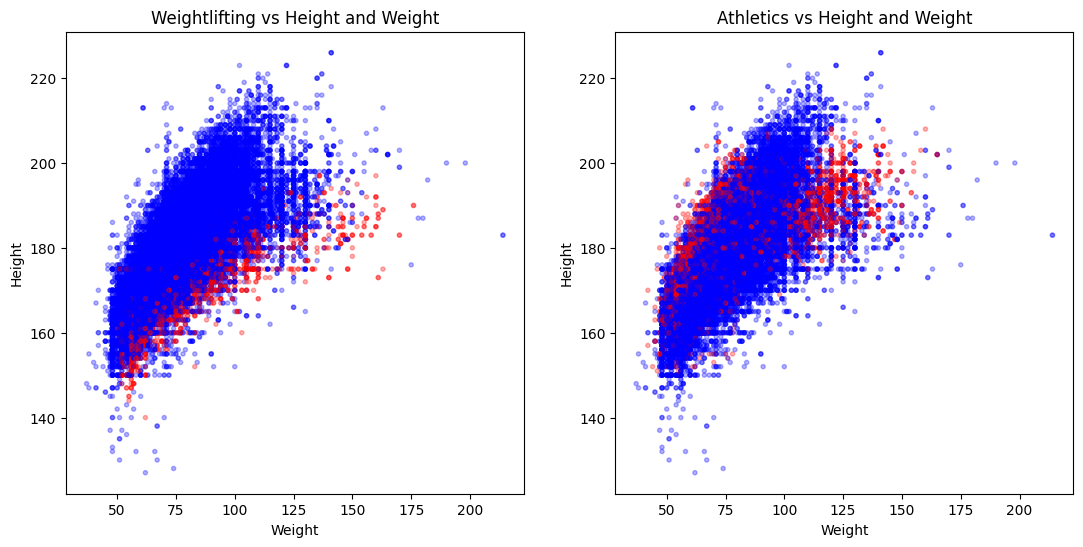

In [110]:
import matplotlib.pyplot as plt

# Assuming X and Y are predefined DataFrames or similar structures with the necessary data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

ax1.scatter(X['Weight'], X['Height'], c=Y['Sport[Weightlifting]'], cmap='bwr', marker='.', alpha=0.3)
ax1.set_title('Weightlifting vs Height and Weight')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')

ax2.scatter(X['Weight'], X['Height'], c=Y['Sport[Athletics]'], cmap='bwr', marker='.', alpha=0.3)
ax2.set_title('Athletics vs Height and Weight')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Height')

plt.show()

#Lets see how well we can predict Weightlifting given height and weight.

In [111]:
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Weightlifting', 1, 0)

In [112]:
# create the y and X matrices
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)

0.966555462731103

 # Predicting Athletics from height and weight


In [113]:
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Athletics', 1, 0)

# create the y and X matrices
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)

0.8607073686802572